### <Center> Лабораторна робота №5. <br> Аналіз демографічних даних

**У завданні Вам пропонується навчити і налаштувати дерева і (при бажанні) випадковий ліс в завданні класифікації на даних Adult сховища UCI.**

Підключаємо необхідні бібліотеки

In [16]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Опис набору даних**

 **[Набір] (http://archive.ics.uci.edu/ml/machine-learning-databases/adult) даних UCI Adult** (качати не треба, все є в репозиторії): класифікація людей за допомогою демографічних даних для прогнозування чи заробляє людина більш \ $ 50 000 в рік.

Опис ознак:

**Age** - вік, кількісна ознака

**Workclass** - тип роботодавця, кількісна ознака

**fnlwgt** - підсумковий вага об'єкта, кількісна ознака

**Education** - рівень освіти, якісна ознака

**Education_Num** - кількість років навчання, кількісна ознака

**Martial_Status** - сімейний стан, категоріальна ознака

**Occupation** - професія, категоріальна ознака

**Relationship** - тип сімейних відносин, категоріальна ознака

**Race** - раса, категоріальна ознака

**Sex** - стать, якісна ознака

**Capital_Gain** - приріст капіталу, кількісна ознака

**Capital_Loss** - втрати капіталу, кількісна ознака

**Hours_per_week** - кількість годин роботи в тиждень, кількісна ознака

**Country** - країна, категоріальна ознака
   
Цільова змінна: **Target** - рівень заробітку, категоріальна (бінарна) ознака

**Зчитуємо навчальну і тестову вибірки.**

In [17]:
data_train = pd.read_csv('lab5/data/adult_train.csv', sep=';') 

In [18]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [19]:
data_test = pd.read_csv('lab5/data/adult_test.csv', sep=';') 

In [20]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [21]:
# необхідно прибрати рядки з неправильними мітками в тестовій вибірці
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# перекодуємо target в числове поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

**Первинний аналіз даних.**

In [22]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data_train['Target'].value_counts()

Target
0    24720
1     7841
Name: count, dtype: int64

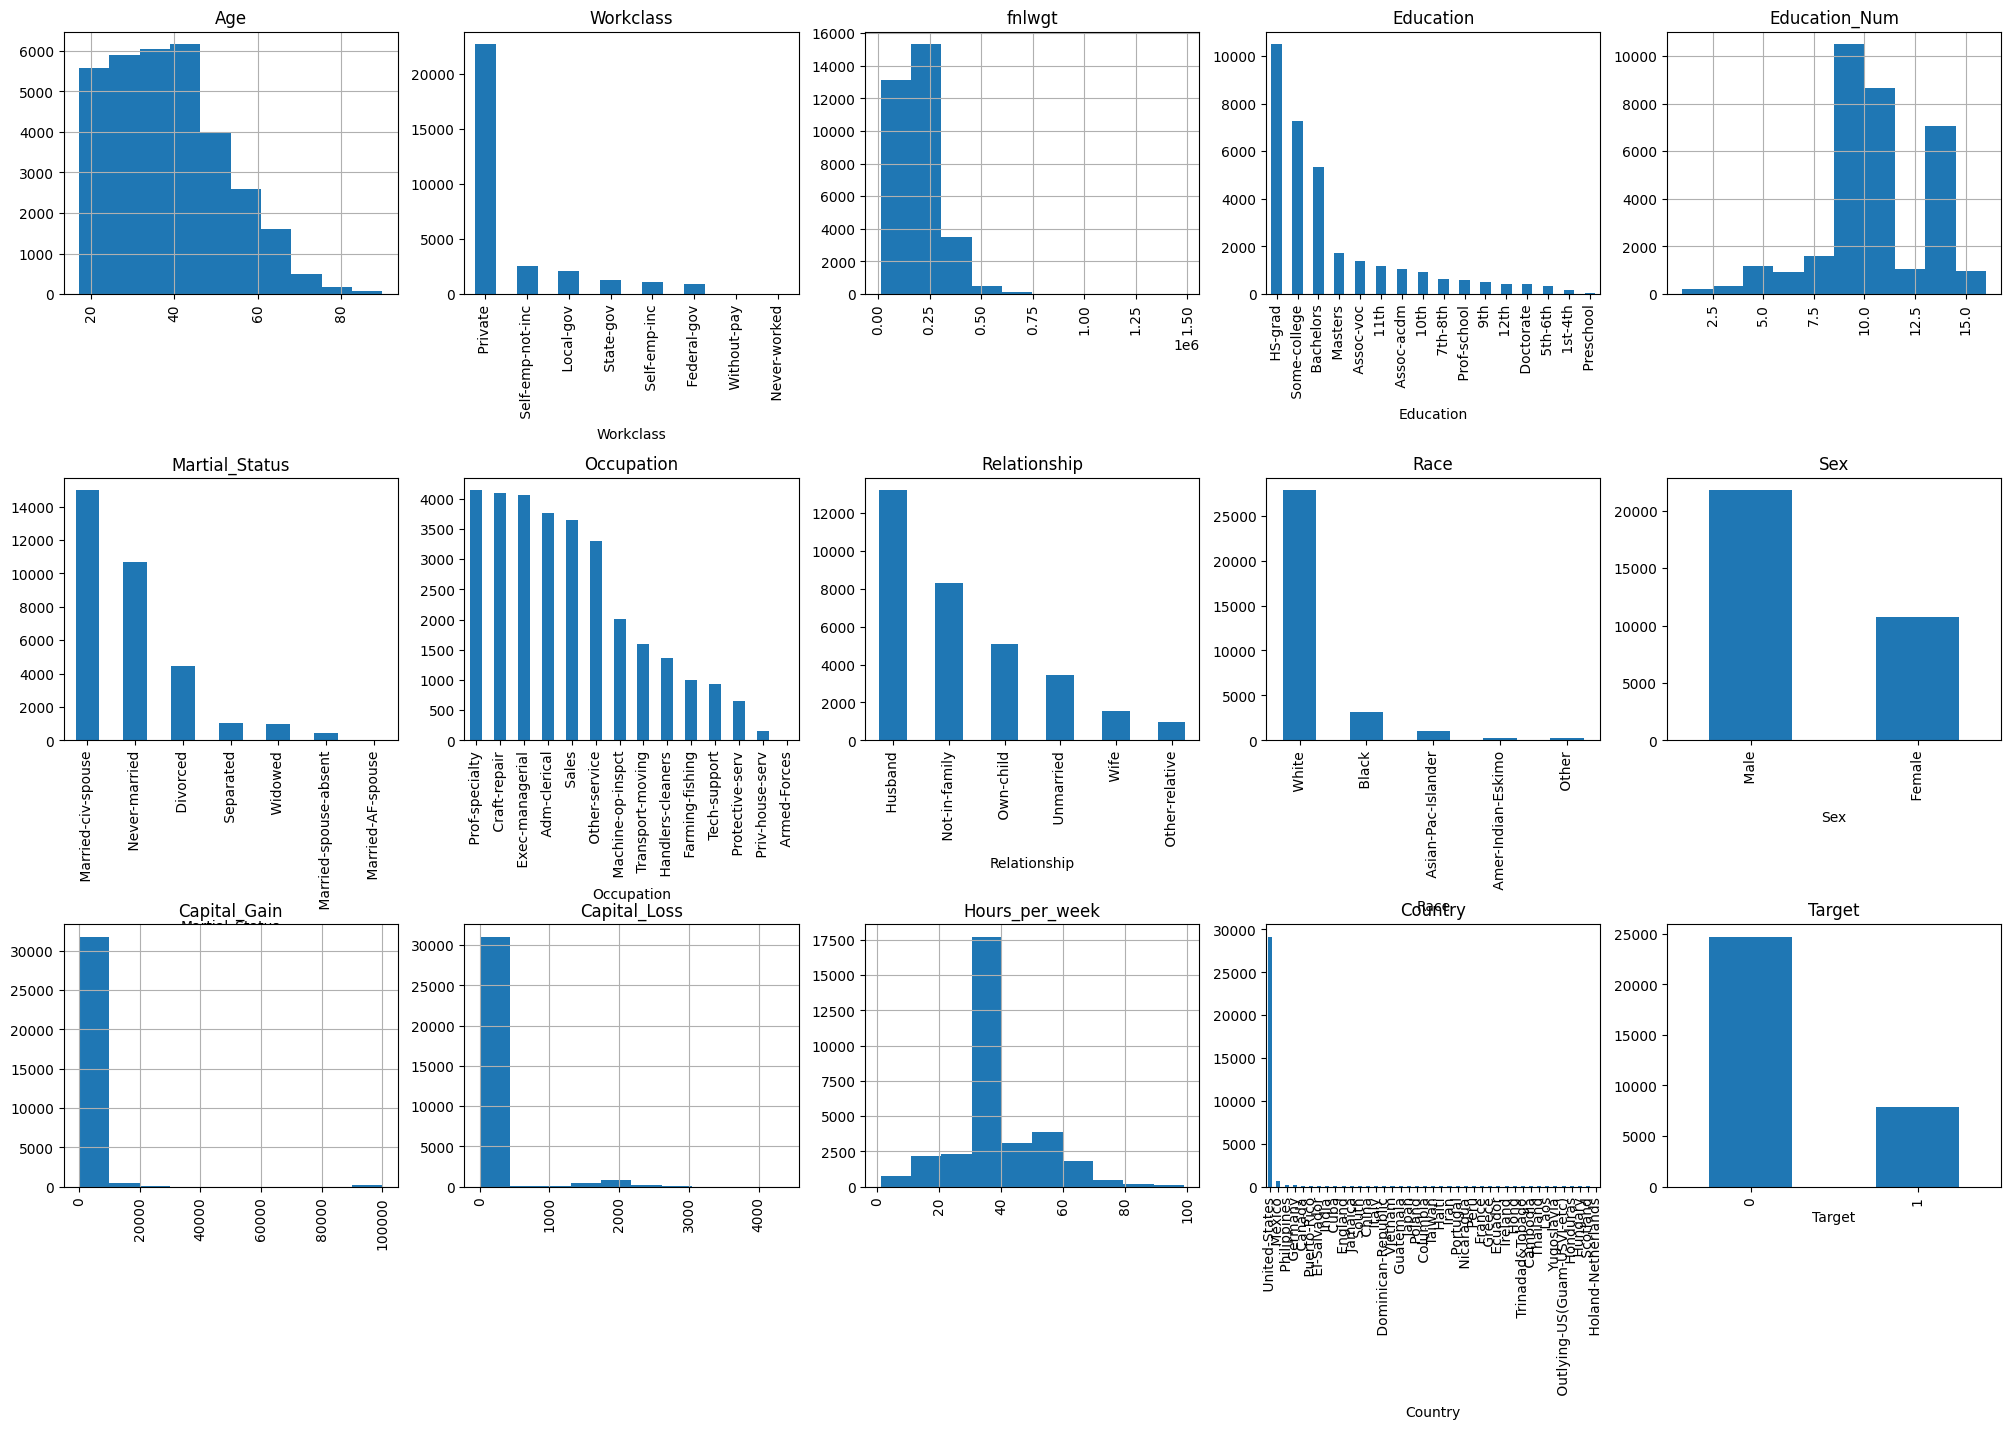

In [25]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Перевіряємо типи даних**

In [26]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [27]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

З'ясувалося, що в тесті вік віднесений до типу object, необхідно це виправити.

In [28]:
data_test['Age'] = data_test['Age'].astype(int)

Також подамо показники типу float як int для відповідності train і test вибірок.

In [29]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заповнимо пропуски в кількісних полях медіанним значенням, а в категоріальних -  значенням, що найчастіше зустрічається**

In [30]:
# виділимо в вибірках категоріальні і числові поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [31]:
# заповнимо пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

C:\Users\User\AppData\Local\Temp\ipykernel_2240\768897896.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train[c] = data_train[c].fillna(data_train[c].mode())
C:\Users\User\AppData\Local\Temp\ipykernel_2240\768897896.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test[c] = data_test[c].fillna(data_train[c].mode())


**Кодуємо категоріальні ознаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Це можна зробити за допомогою методу `pandas get_dummies`.**

In [32]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [33]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [34]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281.0,NaN,NaN,NaN,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,NaN,NaN,NaN,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,NaN,NaN,NaN,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...,...,...,...
Country_ Thailand,16281,2,False,16269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Trinadad&Tobago,16281,2,False,16273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ United-States,16281,2,True,14662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Vietnam,16281,2,False,16262,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [36]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**У тестовій вибірці не виявилося Голландії. Заведемо необхідну ознаку з нулів.**

In [37]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [38]:
set(data_train.columns) - set(data_test.columns)

set()

In [39]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [40]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0
2,38,89814,9,0,0,50,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0


In [41]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## Дерево рішень без налаштування параметрів

**Навчіть на наявній вибірці дерево рішень (`DecisionTreeClassifier`) максимальної глибини 3 і отримайте якість на тесті. Використовуйте параметр `random_state` = 17 для відтворюваності результатів.**

In [42]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Зробіть за допомогою отриманої моделі прогноз для тестової вибірки.**

In [43]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
tree_predictions = tree.predict(X_test)

In [44]:
accuracy = accuracy_score(y_test, tree_predictions)
print("Частка правильних прогнозів:", f"{accuracy:.4f}")

Частка правильних прогнозів: 0.8448


<font color='red'>Питання 6.  </font> Яка частка правильних відповідей дерева рішень на тестовій вибірці при максимальній глибині дерева = 3 і random_state = 17?

Відповідь:  0.8448 тобто 84.48%.

## Дерево рішень з налаштуванням параметрів

**Навчіть на наявній вибірці дерево рішень (`DecisionTreeClassifier`, знову` random_state` = 17). Максимальну глибину налаштуйте на крос-валідації за допомогою `GridSearchCV`. Проведіть 5-кратну крос-валідацію**

In [45]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, scoring='accuracy')

locally_best_tree.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=17)
,param_grid,"{'max_depth': range(2, 11)}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [46]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


**Навчіть на наявній вибірці дерево рішень максимальної глибини 9 (це краще значення `max_depth` в моєму випадку) та оцініть частку правильних відповідей на тесті. Використовуйте параметр random_state = 17 для відтворюваності результатів.**

In [47]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy = accuracy_score(y_test, tuned_tree_predictions)

print("Частка правильних прогнозів:", f"{accuracy:.4f}")

Частка правильних прогнозів: 0.8579


<font color='red'>Питання 7.  </font> Яка частка правильних відповідей дерева рішень на тестовій вибірці при максимальній глибині дерева = 9 і random_state = 17?

Відповідь:  0.8579 тобто 85.79%.

## 2.3. Випадковий ліс без налаштування параметрів (опціонально) ¶

**Навчіть на наявній вибірці випадковий ліс (`RandomForestClassifier`), число дерев зробіть рівним ста, а` random_state` = 17.**

In [48]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Зробіть за допомогою отриманої моделі прогноз для тестової вибірки.**

In [49]:
forest_predictions = rf.predict(X_test)

In [50]:
accuracy = accuracy_score(y_test, forest_predictions)
print("Частка правильних прогнозів:", f"{accuracy:.4f}")

Частка правильних прогнозів: 0.8501


## 2.4. Випадковий ліс з налаштуванням параметрів 

**Навчіть на наявній вибірці випадковий ліс (`RandomForestClassifier`). Максимальну глибину і максимальне число ознак для кожного дерева налаштуйте за допомогою GridSearchCV.**

In [ ]:
# Код з початковими параметрами відпрацьовував цілу вічність, тому я значно зменшив їхню кількість.
forest_params = {'max_depth': [10, 15], 'max_features': [10, 30]}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=17), forest_params, cv=5, scoring='accuracy')

locally_best_forest.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=17)
,param_grid,"{'max_depth': [10, 15], 'max_features': [10, 30]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [57]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 15, 'max_features': 30}
Best cross validaton score 0.8645313653547186


**Зробіть за допомогою отриманої моделі прогноз для тестової вибірки.**

In [58]:
tuned_forest_predictions = locally_best_forest.predict(X_test)
accuracy = accuracy_score(y_test, tuned_forest_predictions)

print("Частка правильних прогнозів:", f"{accuracy:.4f}")

Частка правильних прогнозів: 0.8663
